In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 数据准备

In [ ]:
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")

In [ ]:
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip",'r') as z:
    z.extractall(".")    

In [ ]:
import os
train_path='/kaggle/working/train'
filenames=os.listdir(train_path)
# filenames

In [ ]:
#猫狗分类集合
categories=[]
for f in filenames:
    category=f.split(".")[0]
    if category=='dog':
        categories.append('1')
    else:
        categories.append('0')

In [ ]:
len(categories)

In [ ]:
import pandas as pd
train=pd.DataFrame({'file':filenames,'category':categories})
train.head()

In [ ]:
train['category'].value_counts()

# 可视化

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
for i in range(5): #随机抽五张图片
    plt.figure(figsize=(10,10))
    plt.subplot(2,3,i+1)
    img_path=os.path.join(train_path,filenames[i])
    img=image.load_img(img_path)
    plt.imshow(img)
plt.tight_layout()    
plt.show()

# 准备训练模型

In [ ]:
from keras.applications.vgg16 import VGG16
conv=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
conv.trainable=False
conv.summary()

In [ ]:
from keras import models
from keras import layers
from keras import regularizers
model=models.Sequential()
model.add(conv)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

In [ ]:
# 定义优化器，代价函数，训练过程中计算准确率
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
train['category']=train['category'].map({'1':'dog','0':'cat'}) # '0' 是猫，’1‘是狗
from sklearn.model_selection import train_test_split
train,validate=train_test_split(train,train_size=0.8) #分割训练集和验证集

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,         # 数据归一化
    width_shift_range=0.2,  # 随机水平平移
    height_shift_range=0.2, # 随机竖直平移
    shear_range=0.5,        # 随机错切变换
    rotation_range=40,      # 随机旋转度数
    zoom_range=0.2,         # 随机放大
    horizontal_flip=True,   # 水平翻转
    fill_mode='nearest'     # 填充方式
)    

test_datagen=ImageDataGenerator(rescale=1./255) # 数据归一化

In [ ]:
type(category)

In [ ]:
# 生成训练数据
train_generator=train_datagen.flow_from_dataframe(
    train,directory=train_path,
    x_col='file',
    y_col='category',
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')
# 测试数据
test_generator=test_datagen.flow_from_dataframe(
    validate,
    directory=train_path,
    x_col='file',
    y_col='category',
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

In [ ]:
train_generator.class_indices

# 数据填充

In [ ]:
sample=train.sample(n=1)
sample_generator=train_datagen.flow_from_dataframe(
    sample,
    directory=train_path,
    x_col='file',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)
for i in range(6):
    plt.subplot(2,3,i+1)
    for i,l in sample_generator:
        plt.imshow(i[0])
        break
plt.show()        

In [ ]:
history=model.fit(train_generator,steps_per_epoch=1000,epochs=10,validation_data=test_generator,validation_steps=250)

In [ ]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.figure()
plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_accuracy,'b-',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Validation-Accuracy-Curve')
plt.ylim([0,1])
plt.legend()
plt.figure()
plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Validation-loss-Curve')
plt.legend()
plt.ylim([0,1])
plt.show()

# 微调

In [ ]:
train_layer=False
for i in conv.layers:
    if i.name == 'block5_conv1':
        train_layer=True
    if train_layer==True:
        i.trainable=True
        print(i,' :yes')
    else:
        print(i,' :no')

In [ ]:
from keras import optimizers
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['accuracy'])

In [ ]:
history_fine=model.fit(train_generator,steps_per_epoch=1000,epochs=10,validation_data=test_generator,validation_steps=250)

In [ ]:
acc=history_fine.history['accuracy']
val_accuracy=history_fine.history['val_accuracy']
loss=history_fine.history['loss']
val_loss=history_fine.history['val_loss']
epochs=range(1,len(acc)+1)
plt.figure()
plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_accuracy,'b-',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Validation-Accuracy-Curve')
plt.ylim([0,1])
plt.legend()
plt.figure()
plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Validation-loss-Curve')
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
test_path='/kaggle/working/test1'
test_file=os.listdir('/kaggle/working/test1')

In [ ]:
test_df=pd.DataFrame({'file':test_file})
test_df.head()

In [ ]:
test_generator=test_datagen.flow_from_dataframe(test_df,
                                                directory=test_path,
                                                x_col='file',
                                                y_col=None,
                                                class_mode=None,
                                                target_size=(150,150),
                                                batch_size=20,
                                                shuffle=False)

In [ ]:
predict=model.predict(test_generator,steps=625) #预测

# 预测概率

In [ ]:
img=image.load_img(os.path.join(test_path,test_file[0]))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(str(predict[0]))
plt.subplot(1,2,2)
img=image.load_img(os.path.join(test_path,test_file[1]))
plt.imshow(img)
plt.title(str(predict[1]))
plt.show()

In [ ]:
pred=[]
for i in predict:
    if i>0.5:
       pred.append(1)
    else:
        pred.append(0)

In [ ]:
pred

In [ ]:
submission=test_df.copy()
submission['id']=submission['file'].str.split(".").str[0]
submission['label']=pred
submission.drop(['file'],axis=1,inplace=True)
submission['id']=submission['id'].astype('int')
submission=submission.sort_values(by=['id'])
submission.to_csv('submission.csv',index=False)

# 测试

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))
model.save('model_vgg16.h5')

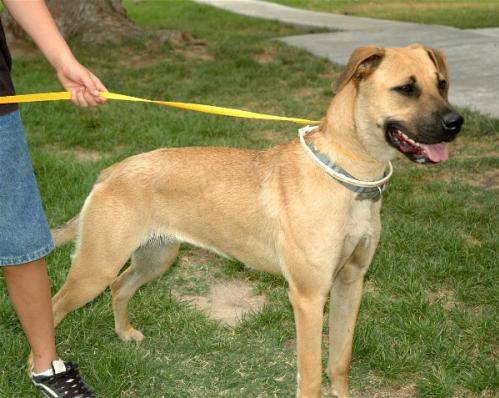

In [47]:

from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.models import load_model
import numpy as np

label = np.array(['cat','dog'])
# 载入模型
model = load_model('model_vgg16.h5')

# 导入图片
image = load_img('/kaggle/working/test1/1003.jpg')
image

In [49]:
image = image.resize((150,150))
image = img_to_array(image)
image = image/255
image = np.expand_dims(image,0)
image.shape

(1, 150, 150, 3)

In [51]:
print(label[model.predict_classes(image)])

[['dog']]
